In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

This notebook explores the shapelet transformers implemented within aeon.

Here you'll learn about the theory behind the shapelet transforms and get a first hand look at how shapelets can boost interpretability using our visualisation module.

We will
- Highlight differences between the four transformers, in order of publishment
- Explain the Gun/No gun problem, this will give the necessary domain knowledge to help with interpreting shapelets 
- Visualise the time series from both classes
- for each transformer:
    - Time how long it takes to fit the data
    - Show what the data is transformed into
    - Explore how different classifiers rank shapelets (only for first transformer)
    - Visualise the extracted shapelets and group them by class
    - Show the best and worst shapelet for each class using Viz module
- Interpret the shapelets, try get some insight to the problem to understand classifications.
- Summarise the differences between each transform

If you want to learn about shapelet classification then go to Antoines shapelet notebook found in [examples\classification\shapelet_based.ipynb](https://www.aeon-toolkit.org/en/stable/examples/classification/shapelet_based.html)

# A little bit about each transformer

In [2]:
import warnings

warnings.filterwarnings("ignore")
from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>
SAST: <class 'aeon.transformations.collection.shapelet_based._sast.SAST'>


We have four transforms, which can be grouped into two categories. Two that focus on improving accuracy and two for improving scalability (reducing computation time). ST and RDST focus on classification accuracy while RSAST and SAST focus on reducing the shapelet generation time.

## Shapelet Transform
The STC introduced a groundbreaking concept by decoupling shapelet generation from the classification process, enabling the transformation of time series data into a separate feature space that can be used with any supervised classifier, such as those available in scikit-learn. 

This innovation significantly improved the accuracy of time series classification compared to the initial shapelet tree algorithm, which was limited to using shapelets within a classification tree framework. The STC iteratively initializes new shapelets, assesses their discriminative power, and removes those that are too similar, ensuring a robust selection of shapelets. 

However, this approach comes with relatively high time complexity due to the need to evaluate a large number of shapelet candidates during the search for the most effective shapelets.

## Scalable and Accurate Subsequence Transform

SAST streamlines shapelet learning by focusing on the idea that shapelets are shared among instances of the same class, thereby avoiding redundant candidates. Unlike previous methods that relied on generating and evaluating shapelet candidates from the entire training set, SAST bypasses this step, arguing that the classifier will inherently assess feature importance during training. This means shapelet selection is more relevant for post hoc interpretability rather than boosting classifier performance. 

Drawing inspiration from 'core object recognition' — where the brain requires only a few instances to recognize objects — SAST asserts that the best shapelets for a class are present in all its instances. 

While performance improves with more reference time series, there's a risk of overfitting. SAST reduces the search space by selecting only a few reference time series per class, thus avoiding the generation of variant shapelets that essentially represent the same pattern. By transforming the data using all subsequences, the classifier learns to focus on the most discriminative features, though this approach may lead to the curse of dimensionality and could be seen as lacking interpretability 'by design'.

One limitation of this transform is its inability to handle multi-variate datasets.

## Random Dilated Shapelet Transform

RDST enhances the shapelet-based classification approach by introducing two additional features for each shapelet within the transformed feature space: 
- the location where the shapelet best matches the time series
- the frequency of its occurrence. 

These features boost the discriminative power of the classifiers. 

A key innovation in RDST is the use of dilation, which allows shapelets to stretch and become noncontiguous, effectively downsampling the data and mitigating noise. Shapelets are randomly selected from the training data, balancing improved accuracy with scalability and interpretability.

A possible limation is that dilation makes the noncontiguous patterns more abstract and harder to be related back to the domain by experts.

## Random Scalable and Accurate Subsequence Transform

RSAST builds on the SAST framework by employing a stratified sampling strategy for subsequence selection, further reducing the search space of shapelets, particularly for longer time series. RSAST starts by pre-computing weights using ANOVA, which guides the selection of initial points for subsequences. It then randomly selects a few time series per class and uses ACF and PACF to identify highly correlated lagged values, which serve as potential lengths for the shapelets. Shapelets are then extracted based on a predefined number of admissible starting points, transforming the original dataset into a feature space where each time series is represented by its distance to each selected subsequence. 

Along with SAST this transform is limited to univariate datasets.

# The Gunpoint classification problem

The Gun/NoGun motion capture dataset is perhaps the most studied time
series classification problem in the literature.

This dataset involves one female actor and one male actor making a motion with their hand, sometimes holding a gun and sometimes not. The classification problem is to determine whether or not they were holding a prop or just miming the action. The problem is made somewhat more complicated by the fact that the two actors, differ in height (by 12 inches) and “style”, something you wil ntoice when we visualise the time series.

The two classes are:

Gun-Draw:
- the actors have their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. 

Point:
- the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. 

For both classes, the research tracked the centroid of the actor's right hand in both X- and Y-axes, which appeared to be highly correlated. Because of this, the data in the archive is only the X-axis - making this a univariate time series. In the dataset Class 1 is "gun" and class 2 is "no gun" (pointing).

In [3]:
import numpy as np

from aeon.datasets import load_classification

X_gun_train, y_gun_train = load_classification("GunPoint", split="train")
X_gun_test, y_gun_test = load_classification("GunPoint", split="test")

X_gun_full = np.concatenate((X_gun_train, X_gun_test), axis=0)

print(f"Shape of the dataset: {X_gun_full.shape}")
print(f"Number of channels = {X_gun_train.shape[1]}")
print(f"Length of each time series = {X_gun_train.shape[2]}")
print(f"Number of training samples = {X_gun_train.shape[0]}")
print(f"Number of testing samples = {X_gun_test.shape[0]}")

Shape of the dataset: (200, 1, 150)
Number of channels = 1
Length of each time series = 150
Number of training samples = 50
Number of testing samples = 150


As you can see, we have 200 different time series, each 150 datapoints long. The train/test split follows the original paper with 50 samples taken for training and the rest for testing, with each actor and class being equally represented in each. 

Note: Time series classification follows its on train/test split rather than the more general 70/30 found in wider ML. Eamonn, who was setting up the archive, chose to make the train sets smaller so that the classification problems would even harder to solve!

---


The two graphs below have the time series from the dataset plotted for each class.

*Can we find a difference between class 1 and 2 so that we can classify a given time series?* 

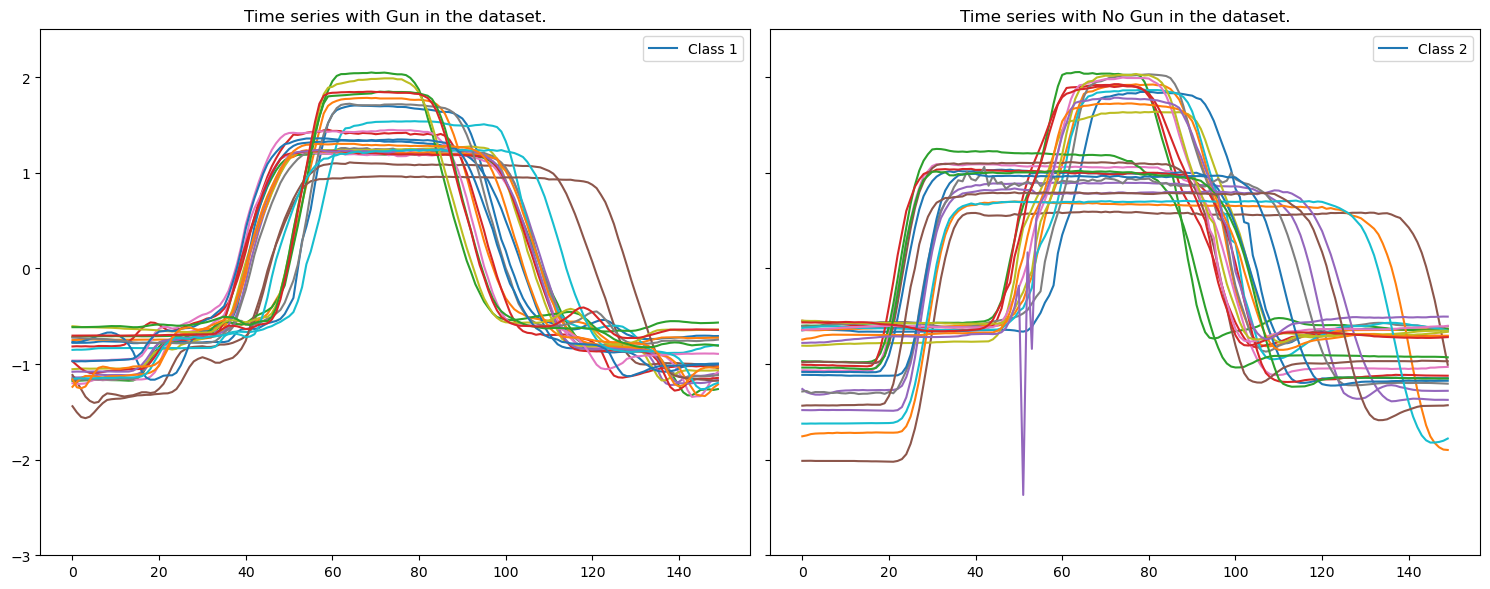

In [4]:
import matplotlib.pyplot as plt

class_1_indices = []
class_2_indices = []

# Populate the class-specific lists
for i in range(0, 50):
    if y_gun_train[i] == "1":
        class_1_indices.append(i)
    elif y_gun_train[i] == "2":
        class_2_indices.append(i)

# Create a figure arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first class
for i in class_1_indices:
    axs[0].plot(X_gun_train[i][0])
axs[0].set_title("Time series with Gun in the dataset.")
axs[0].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[0].legend(["Class 1"])

# Plot the second class
for i in class_2_indices:
    axs[1].plot(X_gun_train[i][0])
axs[1].set_title("Time series with No Gun in the dataset.")
axs[1].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[1].legend(["Class 2"])

plt.tight_layout()
plt.show()

The two plots side by side are hard to look at and the time series as a whole look pretty similar between the two classes.

In both classes we can roughly make out the groups of time series for the female and male actor, one is taller and points for shorter than the other. Unfortunetly we aren't trying to classify the actor but the presence of a gun, a much more subtle difference. 

Looking at the whole pattern seems impractical..

# Exploring each transform's shapelets

Lets take a look at a dataframe representing the testing data, each row is a time series and each column is the value at each time point. 

In [5]:
import pandas as pd

timeseries_list = []
for timeseries in X_gun_test:
    timeseries_list.append(pd.DataFrame(timeseries))
pd.concat(timeseries_list, axis=0, ignore_index=True)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.125013,-1.131338,-1.138288,-1.146687,-1.138639,-1.141431,-1.143691,-1.144379,-1.154912,-1.146421,...,-1.205572,-1.281235,-1.323420,-1.345800,-1.344547,-1.301098,-1.265903,-1.212717,-1.206178,-1.218422
1,-0.626956,-0.625919,-0.627538,-0.626326,-0.624085,-0.624708,-0.625006,-0.624175,-0.624018,-0.622033,...,-0.620019,-0.621505,-0.621526,-0.624091,-0.623989,-0.624350,-0.624376,-0.619471,-0.612058,-0.606422
2,-2.001163,-1.999575,-1.999537,-1.999196,-1.999004,-2.000315,-1.998425,-2.000679,-1.999995,-2.000786,...,0.312798,0.242217,0.145716,0.014012,-0.151780,-0.333427,-0.577435,-0.812720,-1.071147,-1.323383
3,-1.004587,-0.999843,-0.995250,-0.992019,-0.991200,-0.987556,-0.996473,-0.996878,-0.998673,-0.997882,...,-1.080245,-1.060166,-1.044471,-1.039528,-1.040693,-1.044162,-1.044058,-1.044916,-1.044226,-1.043262
4,-0.742625,-0.743770,-0.743900,-0.744873,-0.744745,-0.745364,-0.747078,-0.746615,-0.746705,-0.745859,...,-0.699312,-0.696897,-0.694059,-0.689150,-0.687534,-0.682798,-0.682153,-0.681030,-0.670519,-0.657403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.580006,-0.583332,-0.586108,-0.589118,-0.591951,-0.599196,-0.609292,-0.618504,-0.627164,-0.635995,...,-0.536779,-0.537708,-0.537554,-0.538319,-0.538915,-0.541542,-0.545838,-0.546621,-0.548831,-0.553552
146,-0.728153,-0.730242,-0.733560,-0.734188,-0.734331,-0.734660,-0.733856,-0.733397,-0.732929,-0.731822,...,-0.788042,-0.768710,-0.748156,-0.728561,-0.711126,-0.699604,-0.689584,-0.687476,-0.686448,-0.690183
147,-0.738012,-0.736301,-0.731226,-0.728455,-0.728883,-0.727372,-0.724525,-0.720916,-0.719828,-0.719228,...,-0.617504,-0.613856,-0.611590,-0.609785,-0.609814,-0.608848,-0.610023,-0.609646,-0.608616,-0.612177
148,-1.265111,-1.256093,-1.259421,-1.256351,-1.253265,-1.260103,-1.265063,-1.256396,-1.246350,-1.249132,...,-1.192413,-1.193333,-1.195697,-1.189598,-1.177099,-1.188014,-1.189629,-1.199970,-1.193374,-1.192835


Currently the data is a time series, for which there is a limited number of classifiers. What the shapelet transforms achieve is mapping this data into a form that can be fed to any supervised classifier. They each achieve this slightly differently with their own takes on the transformed output.

In scientific tables, the convention is to have the independent variable in the columns and the dependent variables in the rows. In a time series dataset, time is considered the independent variable because it provides the reference point across which measurements are taken. Each column represents a specific time point. The different time series (or the variables within a time series) —represent the observed values at each time point—are the dependent variables, which are naturally placed in the rows.

#### Random Shapelet Transform

In our exploration of RST we will use the same parameters as the published paper []. 

The aeon implementation matches the experimental parameters explored in the Gunpoint problem, the only parameter which is required to be set is max_shapelets to be 10. MAXLEN is set to the length of
the shortest time series in the training set. For MINLEN, they hardcoded the shortest possible length to three which is the minimum meaningful length. 


You can use the transform directly in aeon, but we will mostly explore it via the transform classifier because it lets us rank the shapelets.

In [6]:
import time

import pandas as pd

from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

start_time = time.time()
rst = RandomShapeletTransform(max_shapelets=10, random_state=99).fit(
    X_gun_train, y_gun_train
)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rst.transform(X_gun_test))

Time taken to fit: 10.4338 seconds


,0,1,2,3,4,5,6,7,8,9
0,0.003717,0.020089,0.043620,1.320980,0.001551,0.008399,0.838023,1.004437,0.900919,0.089512
1,0.133435,0.150480,0.117333,0.033369,0.122150,0.114631,0.040733,0.239368,0.057699,0.009116
2,0.152721,0.193469,0.132979,1.079411,0.187685,0.217339,0.827136,0.935028,0.884864,0.246486
3,0.045800,0.028813,0.019837,1.356602,0.037309,0.026347,0.861129,1.034721,0.935163,0.078142
4,0.045097,0.038882,0.066422,1.358289,0.047304,0.031171,0.865805,1.015214,0.299602,0.051525
...,...,...,...,...,...,...,...,...,...,...
145,0.163862,0.204825,0.143582,0.366795,0.158322,0.149433,0.271026,0.872067,0.214193,0.009775
146,0.051390,0.038367,0.062432,1.337244,0.064614,0.039837,0.847953,1.000116,0.926387,0.049306
147,0.179117,0.217945,0.148447,0.062721,0.171713,0.158122,0.047981,0.259901,0.072351,0.008373
148,0.154436,0.176792,0.129151,0.954934,0.158068,0.166027,0.774495,0.911700,0.841725,0.262808


The dataframe shows what the transformed data looks like. As you can see, we still have the 150 time series, the rows. But now, instead of the columns representing the value at each time point, the columns contain the shortest distance between each of the 10 best shapelets and the time series. This format is no longer a time series and can be treated as a typical classification problem.

If you're wondering how we decided what the 10 best shapelets are, great! Thats a worthy question. During the shapelet generation process we evaluate the discriminative power of each candiadte using a quality measure, in this case information gain. With all candidates measured we choose the 10 most discriminative candidates, 5 for each class.

The dataframe isn't very informative about the shapelets themselves. Lets plot the 10 best shapelets found - the columns above.

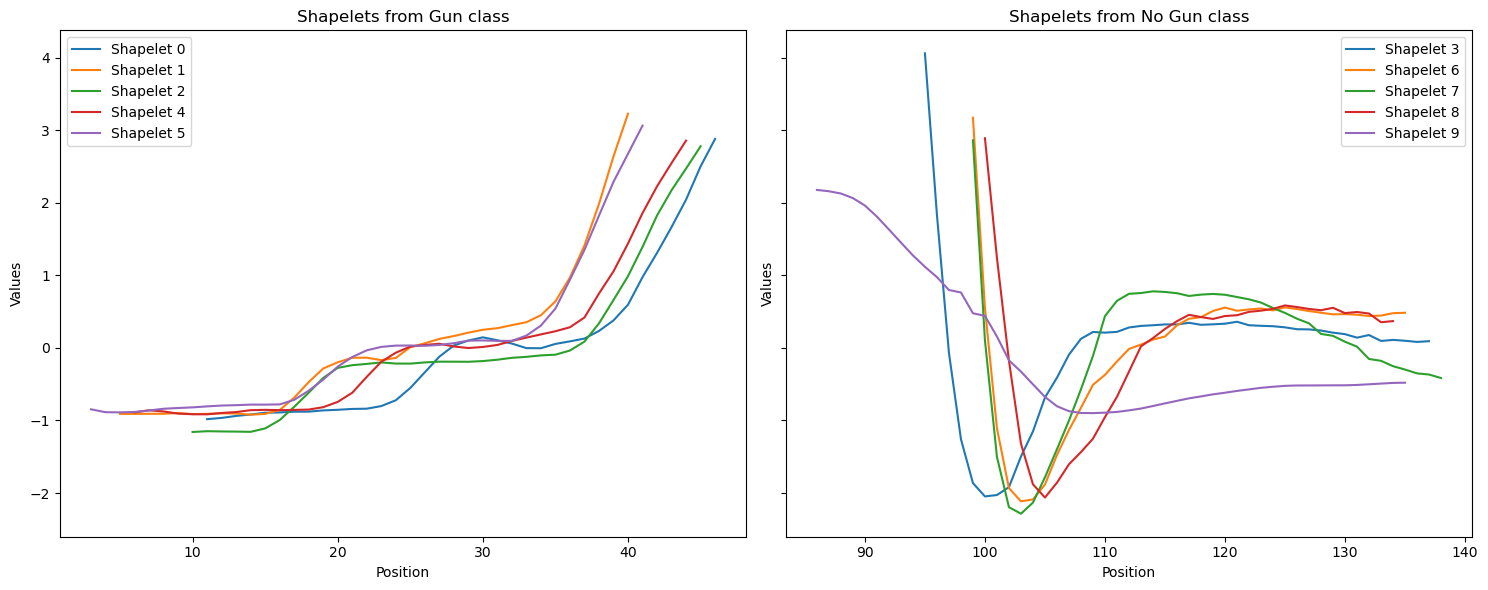

In [7]:
import matplotlib.pyplot as plt

# Define the class of interest
gun_class = "1"
nogun_class = "2"

shapelets = rst.shapelets

shapelet_gun_vals = []
shapelet_gun_pos = []
shapelet_gun_indices = []

shapelet_nogun_vals = []
shapelet_nogun_pos = []
shapelet_nogun_indices = []

for idx, shapelet in enumerate(shapelets):
    if shapelet[5] == gun_class:  # Filter by class
        shapelet_gun_vals.append(shapelet[6])
        shapelet_gun_pos.append(shapelet[2])
        shapelet_gun_indices.append(idx)  # Store the original index

for idx, shapelet in enumerate(shapelets):
    if shapelet[5] == nogun_class:  # Filter by class
        shapelet_nogun_vals.append(shapelet[6])
        shapelet_nogun_pos.append(shapelet[2])
        shapelet_nogun_indices.append(idx)  # Store the original index

# Create a figure with 2 subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets (Gun class)
for i in range(len(shapelet_gun_vals)):
    x_values = [x + shapelet_gun_pos[i] for x in range(len(shapelet_gun_vals[i]))]
    axs[0].plot(
        x_values, shapelet_gun_vals[i], label=f"Shapelet {shapelet_gun_indices[i]}"
    )

axs[0].set_title("Shapelets from Gun class")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")
axs[0].legend()

# Plot the second set of shapelets (No Gun class)
for i in range(len(shapelet_nogun_vals)):
    x_values = [x + shapelet_nogun_pos[i] for x in range(len(shapelet_nogun_vals[i]))]
    axs[1].plot(
        x_values, shapelet_nogun_vals[i], label=f"Shapelet {shapelet_nogun_indices[i]}"
    )

axs[1].set_title("Shapelets from No Gun class")
axs[1].set_xlabel("Position")
axs[1].set_ylabel("Values")
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Isn't this much nicer than the messy time series graph? 

We can much more easily look for the important differences between the two classes now. By generating the best 10 shapelets we have already learned that there is something of interest during the lifting movement and the descending one, in fact, the two distinct groups of shapelets correspond to each class. This means there is a small pattern specific to raising the gun, and one for lowering the empty hand.

In [8]:
from collections import Counter

shapelets = rst.shapelets
classes = []
for shapelet in shapelets:
    classes.append(shapelet[5])
Counter(classes)

Counter({'1': 5, '2': 5})

A property of the Shapelet Transform worth noting is that each class must have the same number of shapelets. This might leave out informative shapelets from one class to enforce for this balance. But on the bright side, it lets us pay equal attention to the possible discriminating patterns of each class.

Now lets take a look at how classifiers rank these shapelets relative to one another. Tree based and linear classifiers are inherently interpretable as you can study the weights in the model to understand which feature is more or less important. So lets explore an example of each - a Logistic Regression and a Random Forest.

I emphasise that the purpose is not to evaluate classification performance, but to make use of the feature importance provided by the classifiers to aid in comparing shapelets later down the line. We will explore these two because the rankings are simple to understand, in practise the Ridge Classifier may lead to better performance (than the Logistic Regressor) but the regularisation can make understanding the shapelet rankings less intuative. 

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import ShapeletTransformClassifier

rst_rf = ShapeletTransformClassifier(
    estimator=RandomForestClassifier(ccp_alpha=0.01),
    max_shapelets=10,
    random_state=99,  # Same random state as for the individual transform from above
).fit(X_gun_train, y_gun_train)


rst_lr = ShapeletTransformClassifier(
    estimator=LogisticRegression(),
    max_shapelets=10,
    random_state=99,  # Same random state as for the individual transform from above
).fit(X_gun_train, y_gun_train)

With both STC variants fit, lets make sure that they have the same 10 shapelets as above.

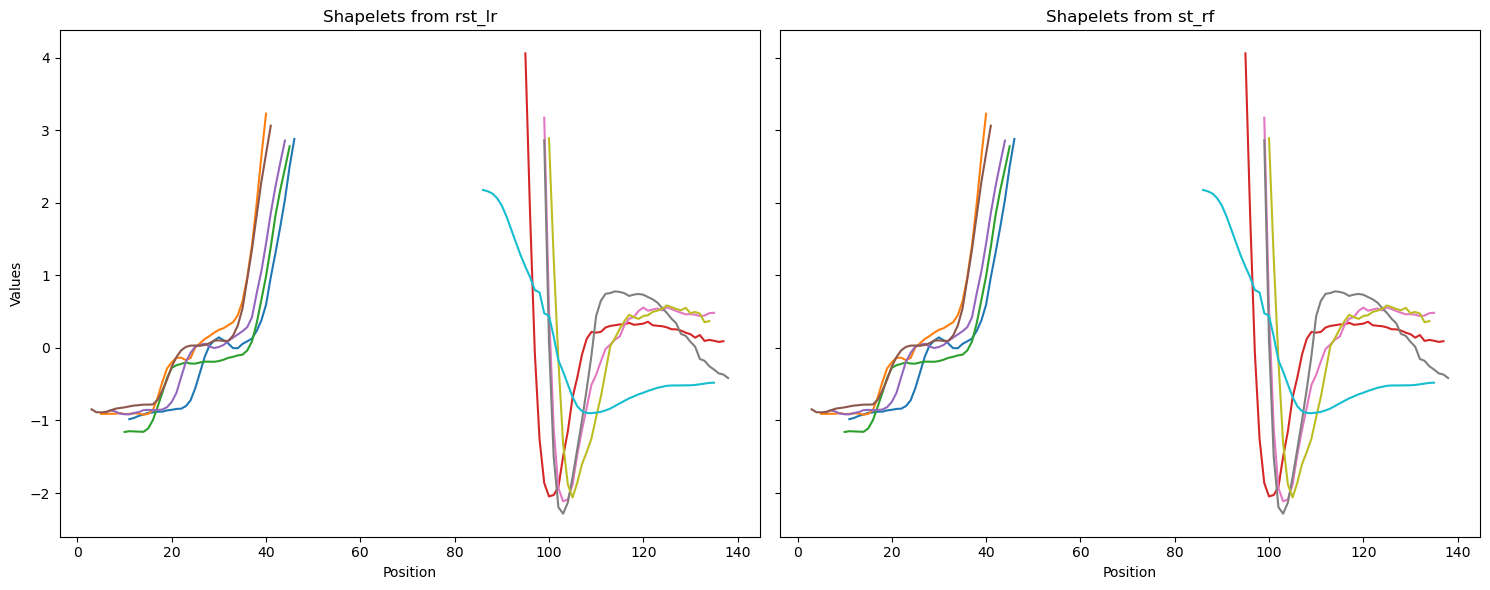

In [10]:
import matplotlib.pyplot as plt

# First set of shapelets (from rst_lr)
shapelets_lr = rst_lr._transformer.shapelets
shapelet_vals_lr = []
shapelet_pos_lr = []

for shapelet in shapelets_lr:
    shapelet_vals_lr.append(shapelet[6])
    shapelet_pos_lr.append(shapelet[2])

# Second set of shapelets (from st_rf)
shapelets_rf = rst_rf._transformer.shapelets
shapelet_vals_rf = []
shapelet_pos_rf = []

for shapelet in shapelets_rf:
    shapelet_vals_rf.append(shapelet[6])
    shapelet_pos_rf.append(shapelet[2])

# Create a figure with 2 subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets (rst_lr)
for i in range(len(shapelet_vals_lr)):
    x_values = [x + shapelet_pos_lr[i] for x in range(len(shapelet_vals_lr[i]))]
    axs[0].plot(x_values, shapelet_vals_lr[i])

axs[0].set_title("Shapelets from rst_lr")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")

# Plot the second set of shapelets (st_rf)
for i in range(len(shapelet_vals_rf)):
    x_values = [x + shapelet_pos_rf[i] for x in range(len(shapelet_vals_rf[i]))]
    axs[1].plot(x_values, shapelet_vals_rf[i])

axs[1].set_title("Shapelets from st_rf")
axs[1].set_xlabel("Position")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Great, now we can safely compare their rankings. We will use our shapelet visualisation module made specifically for aiding the interpretability of the transforms.

In [11]:
import pandas as pd

from aeon.visualisation import ShapeletClassifierVisualizer

rst_lr_vis = ShapeletClassifierVisualizer(rst_lr)
rst_rf_vis = ShapeletClassifierVisualizer(rst_rf)

# Define the lists from the output
# TODO: understand why its opposite of what it should be
rst_rf_vis_index_0 = rst_rf_vis._get_shp_importance(0)[0]  # gun
rst_rf_vis_index_1 = rst_rf_vis._get_shp_importance(1)[0]  # no gun
rst_lr_vis_index_0 = rst_lr_vis._get_shp_importance(0)[0]  # gun
rst_lr_vis_index_1 = rst_lr_vis._get_shp_importance(1)[0]  # no gun

# Create a dictionary to store the elements at each position in the lists
elements_in_position = {
    "Rank": list(range(10)),
    "Random forest Gun": rst_rf_vis_index_0,
    "Random forest No Gun": rst_rf_vis_index_1,
    "Logistic Regression Gun": rst_lr_vis_index_0,
    "Logistic Regression No Gun": rst_lr_vis_index_1,
}

# Convert the dictionary to a DataFrame
pd.DataFrame(elements_in_position).set_index("Rank")

,Random forest Gun,Random forest No Gun,Logistic Regression Gun,Logistic Regression No Gun
Rank,,,,
0,0,0,5,3
1,4,4,4,8
2,2,2,1,6
3,3,3,9,7
4,7,7,0,2
5,6,6,2,0
6,1,1,7,9
7,5,5,6,1
8,8,8,8,4


As you can see the different classifiers find the same shapelets to be of different importance. 

Two patterns emerge in the importance ranking, the Random Forest finds the same shapelets equally important for both classes while the Logistic Regressor flips the importance for each class. This makes sense, given RFs are tree-based and use information gain as the quality measure, the most discrimintaive shapelet is the best at distinguishing the two classes so its just as important for both. While the importance for the Logistic Regressor is found using the coefficients assigned to the features (in this case shapelets), a linear model, assigns positive or negative coefficients to features based on how strongly they correlate with each class. This means that a shapelet contributing positively to one class will contribute negatively to another, resulting in a flip in importance across classes.

This is a good time to remind you of an argument made by SAST. Ranking shapelets independently to the classifier may harm performance. We have just first hand seen how different classifier families rate the shapelets. What if the Logistic Regression Classifier really liked a shapelet ranked 15th according to information gain?

Lets take a look at each classifier's most important shapelet. 

But first we should understand how they are represented in our visalisation module.

- Boxplot of Min (Top Left): The distribution of the minimum distances between the shapelet and each class. As expected, the shapelet fits class 0 more consistently than the other.

- Best Match on Examples (Top Right): This graph shows how the shapelet fits a random time series from each class. The shapelet should, and does, align more closely with the time series of class 0.

- Shapelet Params (Bottom Left): This graph displays the shapelet's pattern and length. 

- Distance Vectors of Examples (Bottom Right): This graph offers a comparison of how well the shapelet fits the two time series, from the 'Best Match on Examples' graph, at each point.

Due to label encoding Class 0 related to '1' which is Gun & Class 1 related to '2' which is No Gun.

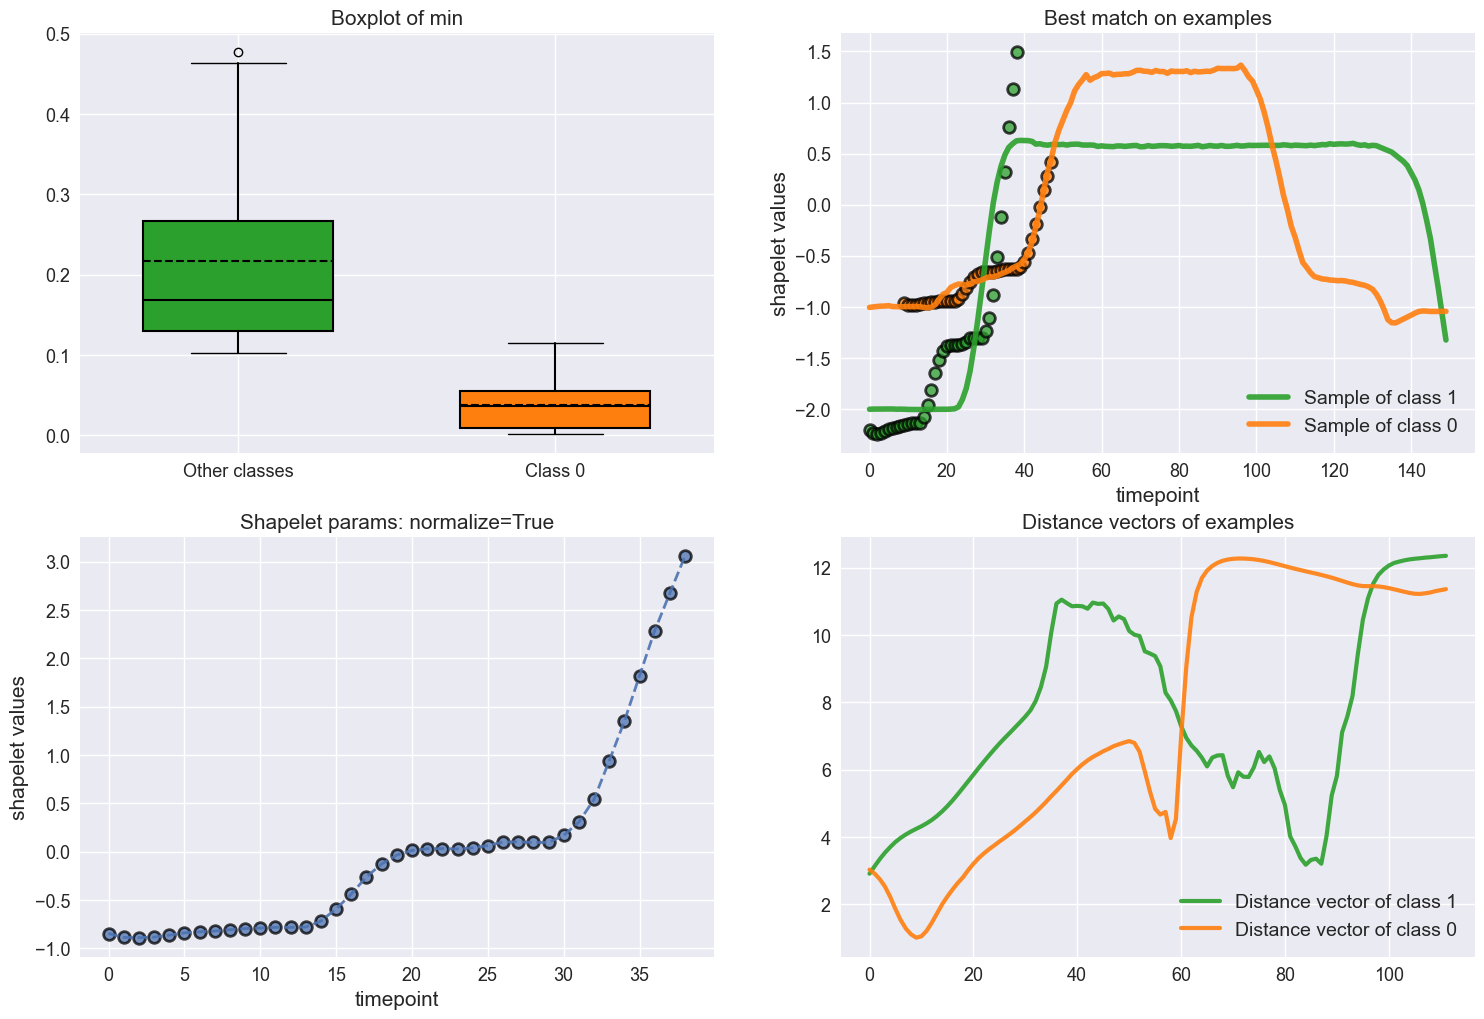

In [12]:
fig = rst_lr_vis.visualize_shapelets_one_class(  # this is worst for other class
    X_gun_test,
    y_gun_test,
    0,  # Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

If you're wondering why the same shapelet looks different when fit to the orange and green time series; that is due to the normalisation parameter, this will become even more apparent in later graphs. 

This parameter normalises the distance between the shapelet and the subseries enabling scale invariance. This means, no matter the amplitude of the pattern, it will be noticed, if it's present. Think of the two actors who have different heights, if they both shrug their shoulders when holding the real gun the change in height will be different but normalisation generalises the pattern to be found in them both.

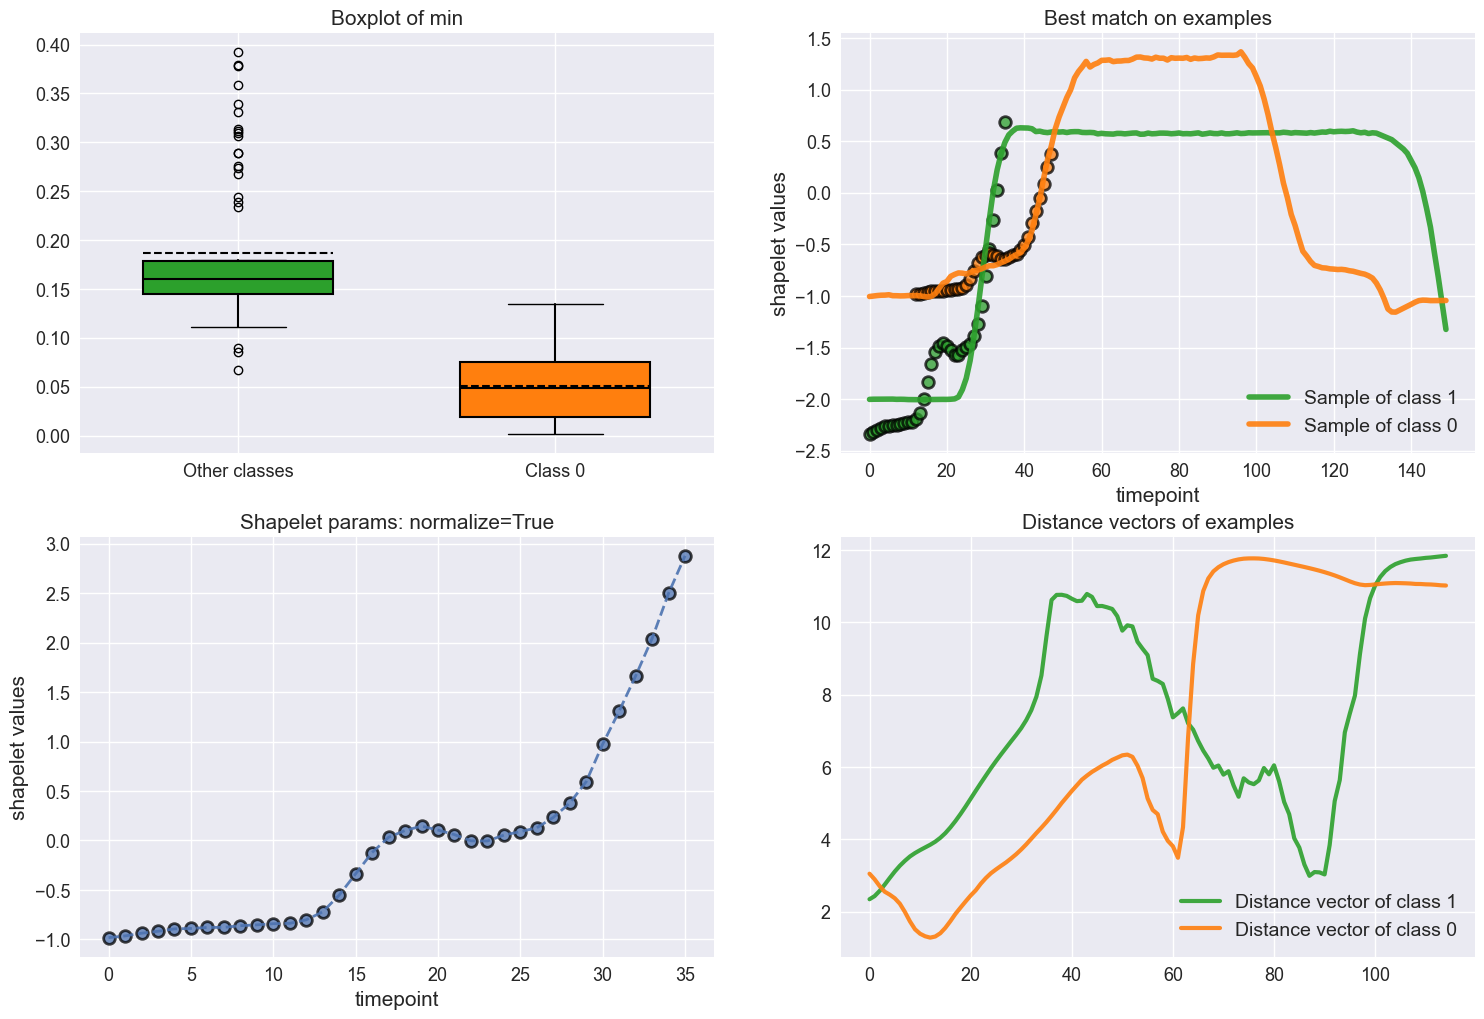

In [13]:
fig = rst_rf_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

Here we learn that for the Logistic Regressor, the most important shapelet for discriminating the No Gun class is found during the raise action rather than descent. The shapelet's fit to the time series from the No Gun class is consistent but there is relativley more variation in its fit for the other, which is why its not very discrimintive for the Gun class.

Interestingly for the Random FOrest, the best shapelet is relating to the raise and it comes from the Gun Class. Remember, for Random Forests feature importance is independent to class. The boxplot reemphasises that the shapelet is ranked first for both classes by the little variance in distances. There is a clear seperation between the two, which is roughly the idea of reduciing entropy.

By seeing the shapelet's best fit on the opposing class, we begin to identify the pattern present in its class and not in the other. By the definiton of shapelets, we know that the pattern of a class' shapelet won't be found in the other class' time series - we don't need to plot this shapelet against all instances of the other class to validate the claim. In the case of the Random Forest's Gun shapelet; there is two step raise which is highlighted when superposed ontop of a time series from the No Gun class which rises in one go. Perhaps this could be explained by the idea that the gun in the holster takes some time to get out where as the basic point action requires the actor to just raise their hand. Currently its hard to understand the No Gun shapelet, due to the normalisation but keep an eye out - you might spot the difference :)

Now, lets take a look at the worst shapelets.

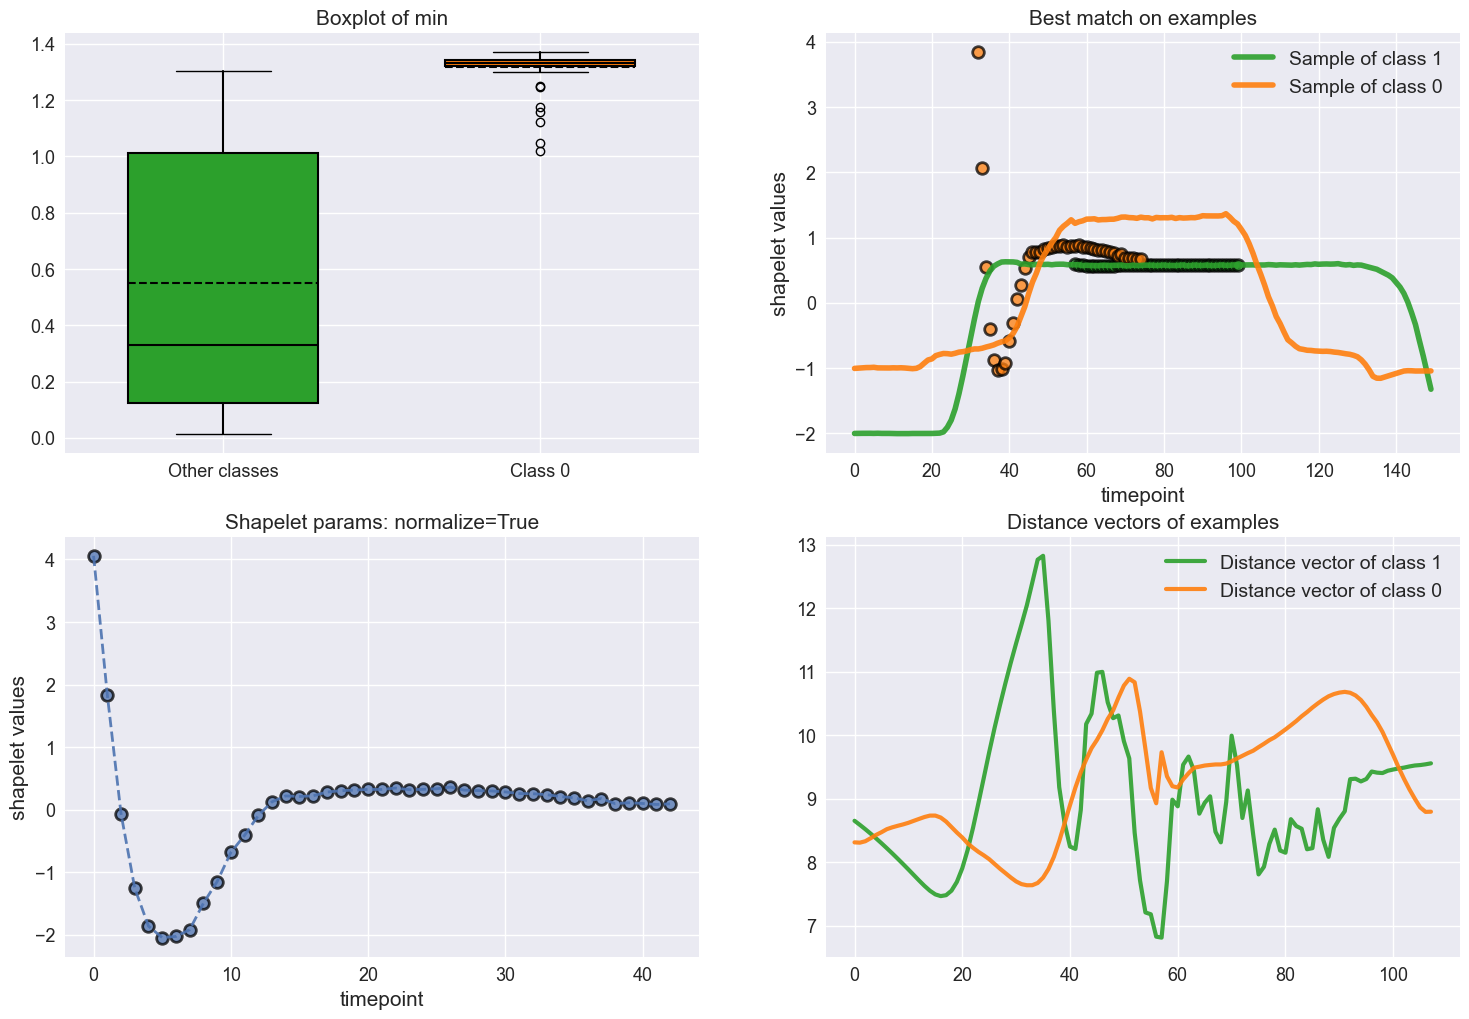

In [14]:
fig = rst_lr_vis.visualize_shapelets_one_class(  # this is best for other class
    X_gun_test,
    y_gun_test,
    0,  # Gun
    best=False,  # Showing worst shapelet for Gun which should be best for No Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

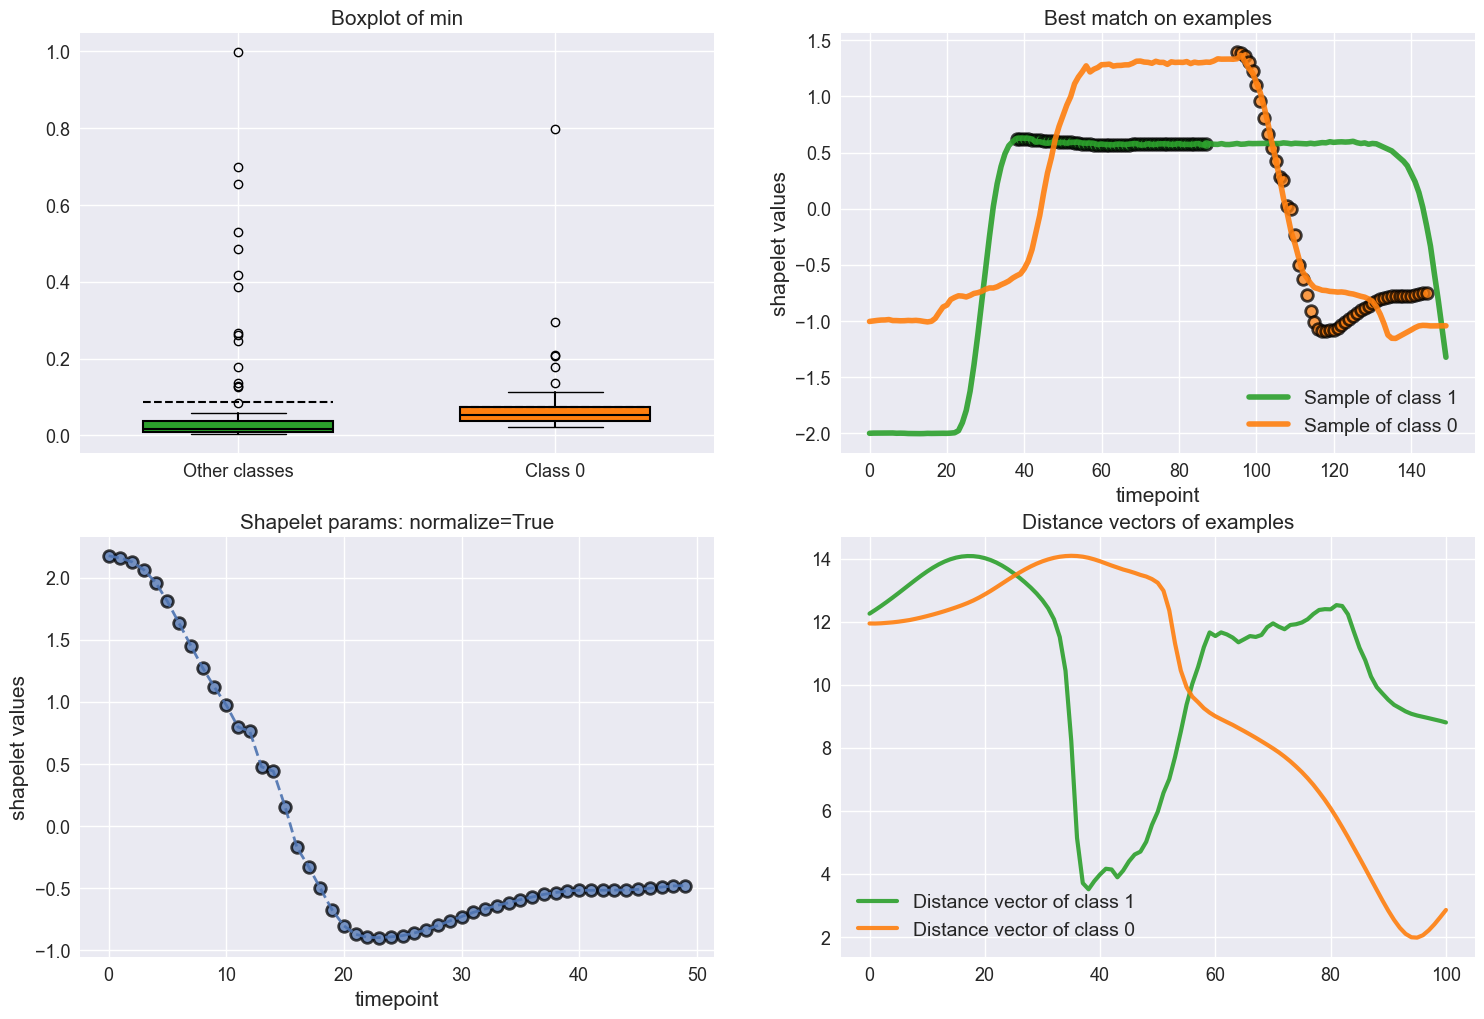

In [15]:
fig = rst_rf_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

It seems intuitive to think that the worst shapelet is going to be further from its class' time series than the best. But this is an erronous thought, what makes a shapelet valuable to a classifier is not how well it fits its own class but how differently it fits the other. The perfect shapelet will fit its class while being completely incompatible to the other. Thats why if you compare the distance plots of the best and worst shapelets they're not that different, also take into account these are the 10 best out of the 10,000 candidates. We should really be saying 'least best'.

The Logistic Regressor's worst shapelet for the No Gun class it the best shapelet for the Gun class. Here we see the same insight provided by the Random FOrests best shapelet. That two step raise is specific to the Gun Class. This is actually why thw box plot for the worst shapelet doesn't look like that for the Random Forest, the least discriminative shapelet will be ranked somewhere around the middle.

By plotting the worst shapelet according to the Random Forest, we see that the box plots of the distance distribution for both classes are very similar. Meaning there is no threshold to split the two classes.

#### Random Dilated Shapelet Transform

This paper did not explore the Gunpoint problem, however the default parameters were defined as:

- proportion of z-normalised shapelets = 0.8
- number of shapelets to generate = 10000
- the set of possible lengths of shapelets = [11]
- The percentile boundaries used to sample the occurrence threshold: P1 = 5, P2 = 10

In [16]:
import time

from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform,
)

shapelet_lengths = array = list(range(3, 151))

start_time = time.time()
rdst = RandomDilatedShapeletTransform(
    max_shapelets=10, shapelet_lengths=shapelet_lengths, random_state=99
).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rdst.transform(X_gun_test))

Time taken to fit: 60.5879 seconds


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,90.434199,3.0,0.0,17.355638,75.0,7.0,10.386658,0.0,26.0,40.179315,...,21.0,56.148556,40.0,2.0,9.551824,0.0,5.0,52.913176,7.0,8.0
1,135.849066,6.0,0.0,3.686757,71.0,17.0,1.642856,16.0,31.0,84.113754,...,34.0,27.728299,33.0,16.0,80.008337,0.0,0.0,103.219560,5.0,0.0
2,33.562295,12.0,19.0,38.949554,75.0,0.0,31.059927,0.0,26.0,120.235665,...,38.0,114.101873,40.0,0.0,100.936584,0.0,0.0,132.838340,7.0,0.0
3,102.310401,6.0,0.0,16.735445,75.0,6.0,7.344196,6.0,32.0,54.277397,...,28.0,44.031600,40.0,12.0,13.385243,2.0,7.0,67.742900,7.0,8.0
4,128.388239,0.0,0.0,3.359251,72.0,19.0,4.339736,12.0,30.0,70.461800,...,29.0,14.162884,34.0,18.0,62.584215,3.0,0.0,90.738198,7.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,135.355015,18.0,0.0,4.208665,66.0,23.0,2.440272,10.0,25.0,85.008389,...,34.0,26.381014,27.0,20.0,79.696595,2.0,0.0,105.337189,0.0,0.0
146,127.067882,6.0,0.0,8.040580,75.0,12.0,4.457694,18.0,36.0,81.911406,...,36.0,10.108008,40.0,12.0,59.300146,7.0,0.0,99.294487,7.0,0.0
147,129.879600,18.0,0.0,2.949177,75.0,15.0,4.560666,14.0,32.0,71.675794,...,31.0,8.895907,36.0,16.0,62.762211,7.0,0.0,91.516401,7.0,3.0
148,55.464392,1.0,6.0,29.185184,75.0,0.0,25.963341,0.0,16.0,63.351727,...,16.0,87.586437,40.0,0.0,60.177518,8.0,0.0,65.302530,7.0,8.0


The RDST has 3 times as many features than the RST for the same number of shapelets. That is because along with the shortest distance to each time series, every shapelet's number of occurances and the position of the closest fit. Because of these two additional features we no hve the ability to discrimintate time series in four ways.
- A shapelet is present in one class and not the other.
- A shapelet is present in both classes but in different locations.
- A shapelet is present in both classes but in different scales. can't normalise and also need to dilate. Introduce normalisation likelihood parameter.
- A shapelet is present in both classes but occurs a different number of times.
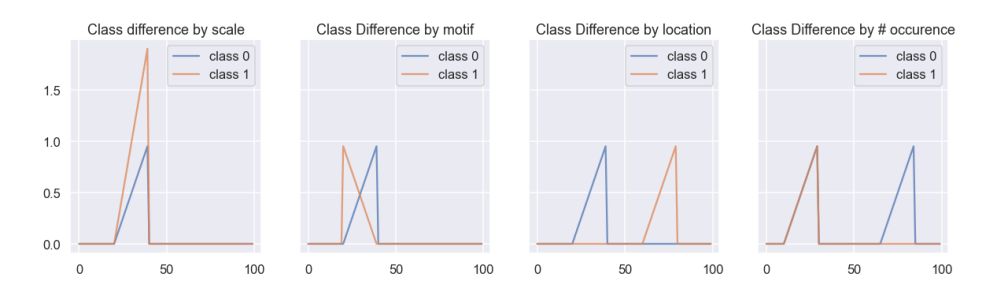

Looking at the dataframe we see that the features aren't grouped nor ordered, we don't need to tell the classifier which features relate to which shapelet because it will learn these relations during training. Shiffling the columns would have no impact on performance.

In [17]:
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import RDSTClassifier

shapelet_lengths = array = list(range(3, 151))
rdst_lr = RDSTClassifier(
    estimator=LogisticRegression(max_iter=500),
    max_shapelets=10,
    save_transformed_data=True,
    shapelet_lengths=[9, 11, 13],
    random_state=99,
).fit(X_gun_train, y_gun_train)

With our transformer (and classifier) fit, let's take a look at which 10 shapelets were extracted using RTSD.

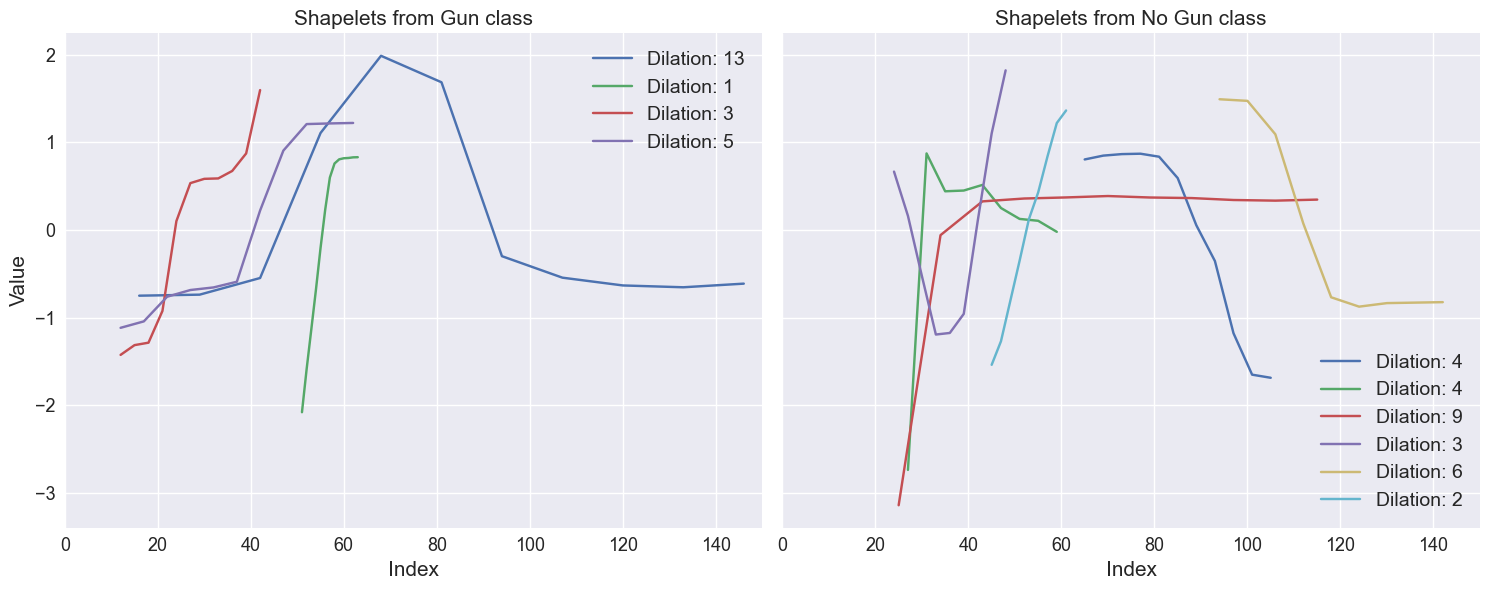

In [18]:
import matplotlib.pyplot as plt

shapelets_lr = rdst_lr._transformer.shapelets_
shapelet_vals_lr = shapelets_lr[0]
shapelet_pos_lr = shapelets_lr[1]
shapelet_dilation = shapelets_lr[3]
shapelet_classes = shapelets_lr[8]  # Class labels

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot each shapelet in its respective subplot based on its class
for idx, shapelet in enumerate(shapelet_vals_lr):
    dilation = shapelet_dilation[idx]
    startpoint = shapelet_pos_lr[idx]
    x_values = [startpoint + i * dilation for i in range(len(shapelet[0]))]

    if shapelet_classes[idx] == 0:
        axs[0].plot(x_values, shapelet[0], label=f"Dilation: {dilation}")
    else:
        axs[1].plot(x_values, shapelet[0], label=f"Dilation: {dilation}")

# Customize the first subplot for class 0
axs[0].set_title("Shapelets from Gun class")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].set_xlim(0, 150)

# Customize the second subplot for class 1
axs[1].set_title("Shapelets from No Gun class")
axs[1].set_xlabel("Index")
axs[1].legend()
axs[1].set_xlim(0, 150)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

As you can see we have very different shapelets extracted with RDST. Some may look jagged because of the dilation - comment out the random state parameter and generate them a few times. With out the random state you might notice that with this transformer the generated shapelets are more random because the shapelet candidate space is much larger now due to the introduction of dilation.

At this point dilation does appear to harm interpretability since dilated shapelets won't be familiar to domain experts and plotting them ontop of time series often leads to them not fitting as perfectly as the other transforms. But we have more interpretable power through exploring global and local patterns as you'll see later.

In [19]:
import pandas as pd

from aeon.visualisation import ShapeletClassifierVisualizer

rdst_lr_vis = ShapeletClassifierVisualizer(rdst_lr)

# Define the lists from the output
rdst_lr_vis_index_0 = (
    pd.Series(rdst_lr_vis._get_shp_importance(0)[0]).drop_duplicates().to_list()
)
rdst_lr_vis_index_1 = (
    pd.Series(rdst_lr_vis._get_shp_importance(1)[0]).drop_duplicates().to_list()
)

# Create a dictionary to store the elements at each position in the lists
elements_in_position = {
    "Rank": list(range(len(rdst_lr_vis_index_0))),
    "Logistic Regression classifier Gun": rdst_lr_vis_index_0,
    "Logistic Regression classifier No Gun": rdst_lr_vis_index_1,
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(elements_in_position).set_index("Rank")
df

,Logistic Regression classifier Gun,Logistic Regression classifier No Gun
Rank,,
0,9,6
1,0,4
2,1,8
3,7,2
4,5,3
5,3,5
6,2,7
7,8,1
8,4,0


Because there are three seperate features for ech shapelet, we find a shapelet's importance by averaging the three features corresponding to it.

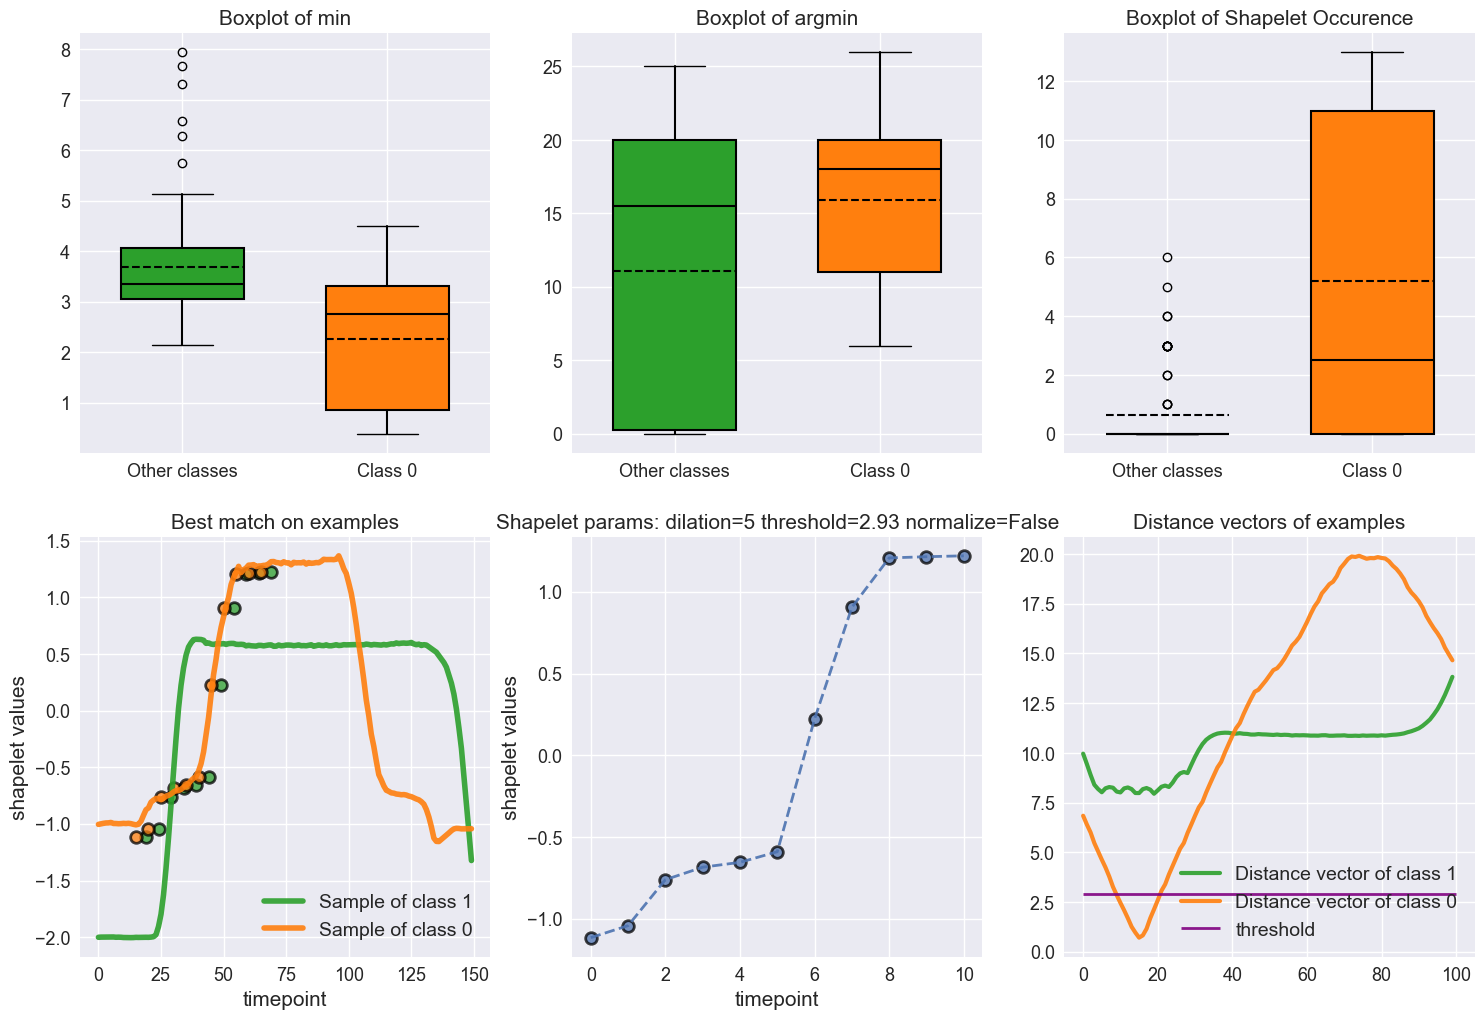

In [20]:
fig = rdst_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 3},
)

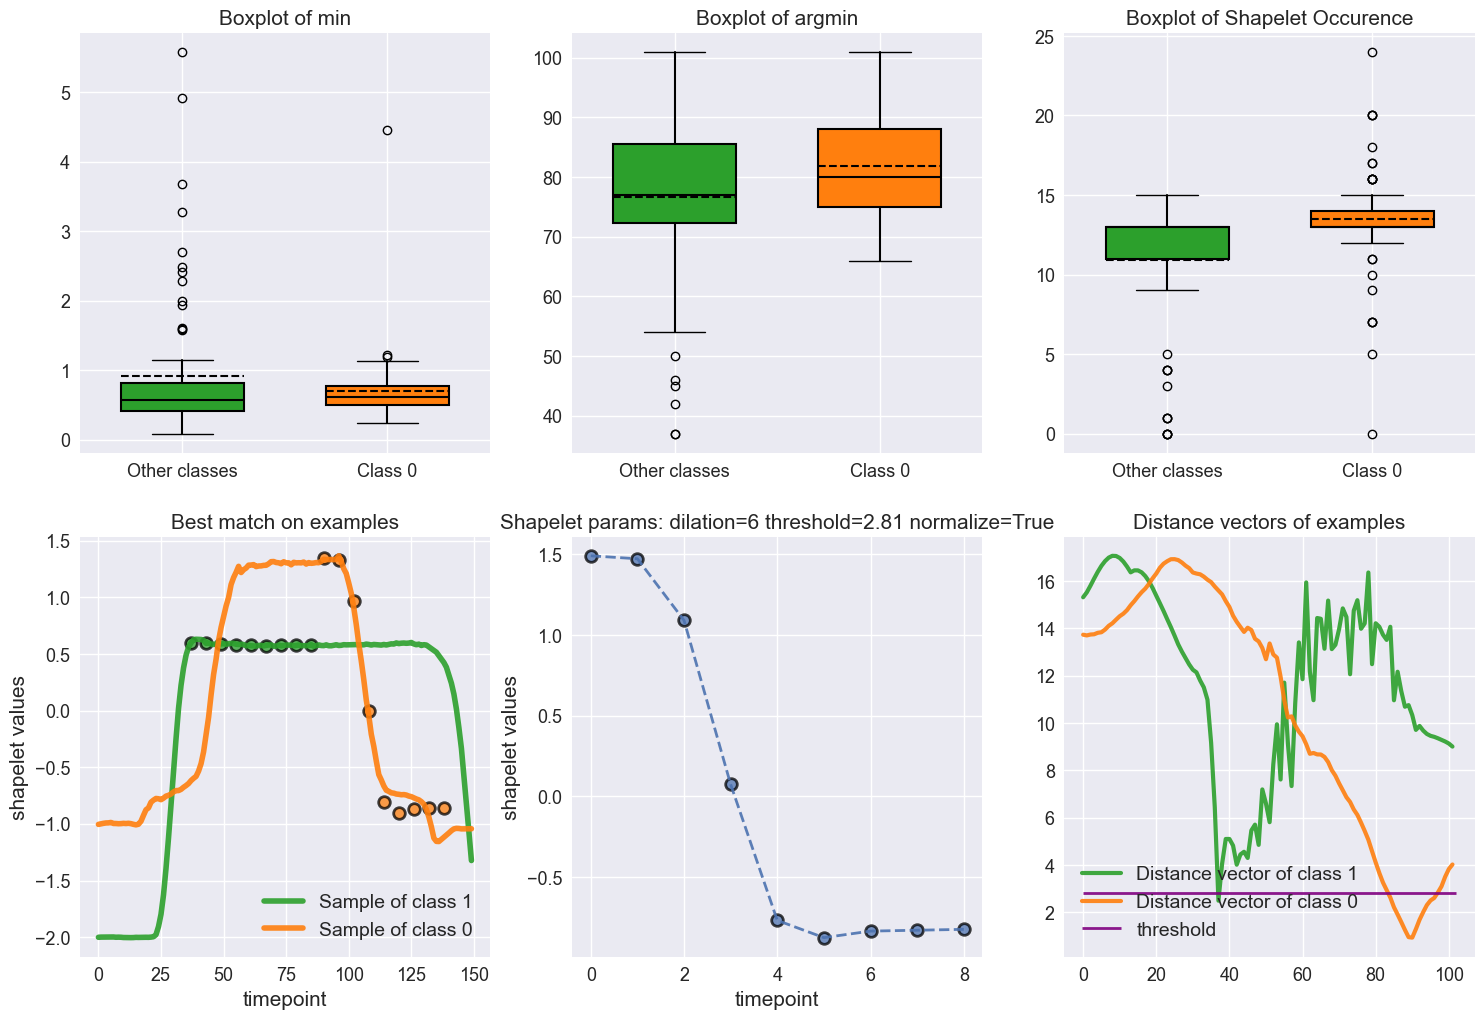

In [21]:
fig = rdst_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    best=False,  # This is best for No Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 3},
)

Look at that, we have so much more information to help us in understanding the Gunpoint problem.
These plots introduce three new peices of information:
1. A box plot of the best match positions for each class.
2. A box plot of the number of occurences for each class.
3. The threshold value for accepting a subseries as a shapelet match.

The above two plots show the best shapelet for each class ranked by the Logistic Regressor, the top being the best for No Gun and the bottom for Gun.

#### Scalable and Accurate Subsequence Transform

In [ ]:
import time

from aeon.transformations.collection.shapelet_based import SAST

start_time = time.time()
sast = SAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(sast.transform(X_gun_test))

SAST [1]_ first randomly selects 1 time series from each class (they are called
    reference time series). Then SAST generates all the subsequences of the
    specified lengths from these reference time series. These subsequences
    are then used to transform a time series dataset, replacing each time
    series by the vector of its distance to each subsequence.

Unlike the previous two SAST doesn't select these so called best subseries, so before we plot we need to chose 10 to visualise.

Here, we are training a random forest classifier on the transformed data. The purpose is not to evaluate classification performance but to make use of the feature importance provided by the Random Forest to aid in comparing shapelets further on.

In [ ]:
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import SASTClassifier

sast_lr = SASTClassifier(
    classifier=LogisticRegression(),
    seed=0,
    nb_inst_per_class=10,
).fit(X_gun_train, y_gun_train)

In the case where subsampling completely
removes one actor from the training data, the performance on the test set, where the two
actors are present, could be reduced.

In [ ]:
from operator import itemgetter

feature_importance = abs(sast_lr._pipeline[-1].coef_[0])

subseries = sast_lr._transformer._kernel_orig
norm_subseries = sast_lr._transformer._kernels
start_pos = sast_lr._transformer._start_positions
classes = sast_lr._transformer._classes
time_series_indexes = sast_lr._transformer._source_series
# Combine shapelets with their feature importance, start positions, and class info
features = zip(
    subseries,
    norm_subseries,
    feature_importance,
    start_pos,
    classes,
    time_series_indexes,
)

# Sort features by importance (descending order)
sorted_features = sorted(features, key=itemgetter(2), reverse=True)

# Extract sorted shapelets, start positions, and class info
subseries = [feature[0] for feature in sorted_features]
norm_subseries = [feature[1] for feature in sorted_features]
start_positions = [feature[3] for feature in sorted_features]
shapelet_classes = [feature[4] for feature in sorted_features]
time_series_indices = [feature[5] for feature in sorted_features]
shapelet_lengths = [len(feature[0]) for feature in sorted_features]

num_shapelets = 10
# Get the top 10 shapelets with their start positions and class information
top_subseries = [
    (subseries, norm_subseries, start_pos, cls)
    for subseries, norm_subseries, start_pos, cls in zip(
        subseries, norm_subseries, start_positions, shapelet_classes
    )
]
shapelets = top_subseries[:num_shapelets]

In [ ]:
np.unique(time_series_indices)

In [ ]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].legend()
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].legend()
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the top 10 shapelets
data = {
    "Time Series Index": time_series_indices[:num_shapelets],
    "Start Position": start_positions[:num_shapelets],
    "Shapelet Length": shapelet_lengths[:num_shapelets],
    "Class": shapelet_classes[:num_shapelets],  # New column for shapelet classes
}
df = pd.DataFrame(data)

# Define the priority order for sorting
priority_order = ["Time Series Index", "Start Position", "Shapelet Length", "Class"]

# Sort the DataFrame by the priority columns
df_sorted = df.sort_values(by=priority_order, ascending=True)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
ax.axis("off")  # Hide the axis

# Create the table
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(df_sorted.columns)

plt.title("Top 10 Shapelets Information")
plt.tight_layout()
plt.show()

Here we learn that the 10 best shapelets from SAST are all from class two, and all come from the first time series input at around the same point with a roughly similar length. This tells us, given how similar they all are in pos & length, that this problem only has one particularly discriminative pattern between the two classes. The two plots show the importance of scale & phase invariance in the shapelets, we can see that they both share the pattern just at different heights.

RDST uses the shapelet pos as a feature which is why it needs to search all time series.

In [ ]:
sast_lr_vis = ShapeletClassifierVisualizer(sast_lr)

fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [ ]:
fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [ ]:
# Filter shapelets by class
best_class_one_shp = [
    (shapelet, start_pos, index)
    for index, (shapelet, start_pos, cls) in enumerate(
        zip(top_subseries, start_positions, shapelet_classes)
    )
    if cls == "1"
][0]

print("Best class one shapelet is ranked", best_class_one_shp[2])

#### Random and Scalable Subsequence Transform

In [ ]:
import time

from aeon.transformations.collection.shapelet_based import RSAST

start_time = time.time()
rsast = RSAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rsast.transform(X_gun_test))

In [ ]:
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import RSASTClassifier

rsast_lr = RSASTClassifier(classifier=LogisticRegression(), seed=0).fit(
    X_gun_train, y_gun_train
)

In [ ]:
from operator import itemgetter

feature_importance = abs(rsast_lr._pipeline[-1].coef_[0])

subseries = rsast_lr._transformer._kernel_orig
norm_subseries = rsast_lr._transformer._kernels
start_pos = rsast_lr._transformer._start_positions
classes = rsast_lr._transformer._classes
time_series_indexes = rsast_lr._transformer._source_series
# Combine shapelets with their feature importance, start positions, and class info
features = zip(
    subseries,
    norm_subseries,
    feature_importance,
    start_pos,
    classes,
    time_series_indexes,
)

# Sort features by importance (descending order)
sorted_features = sorted(features, key=itemgetter(2), reverse=True)

# Extract sorted shapelets, start positions, and class info
subseries = [feature[0] for feature in sorted_features]
norm_subseries = [feature[1] for feature in sorted_features]
start_positions = [feature[3] for feature in sorted_features]
shapelet_classes = [feature[4] for feature in sorted_features]
time_series_indices = [feature[5] for feature in sorted_features]
shapelet_lengths = [len(feature[0]) for feature in sorted_features]

num_shapelets = 10
# Get the top 10 shapelets with their start positions and class information
top_subseries = [
    (subseries, norm_subseries, start_pos, cls)
    for subseries, norm_subseries, start_pos, cls in zip(
        subseries, norm_subseries, start_positions, shapelet_classes
    )
]
shapelets = top_subseries[:num_shapelets]

In [ ]:
np.unique(time_series_indices)

In [ ]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Class 1")
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for Class 2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the top 10 shapelets
data = {
    "Time Series Index": time_series_indices[:num_shapelets],
    "Start Position": start_positions[:num_shapelets],
    "Shapelet Length": shapelet_lengths[:num_shapelets],
    "Class": shapelet_classes[:num_shapelets],  # New column for shapelet classes
}
df = pd.DataFrame(data)

# Define the priority order for sorting
priority_order = ["Time Series Index", "Start Position", "Shapelet Length", "Class"]

# Sort the DataFrame by the priority columns
df_sorted = df.sort_values(by=priority_order, ascending=True)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
ax.axis("off")  # Hide the axis

# Create the table
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(df_sorted.columns)

plt.title("Top 10 Shapelets Information")
plt.tight_layout()
plt.show()

In [ ]:
sast_lr_vis = ShapeletClassifierVisualizer(sast_lr)

fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [ ]:
sast_lr_vis = ShapeletClassifierVisualizer(sast_lr)

fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [ ]:
# Filter shapelets by class
best_class_one_shp = [
    (shapelet, start_pos, index)
    for index, (shapelet, start_pos, cls) in enumerate(
        zip(top_subseries, start_positions, shapelet_classes)
    )
    if cls == "2"
][0]

print("Best class two shapelet is ranked", best_class_one_shp[2])